In [4]:
from collections import Container
import os
import warnings 
warnings.filterwarnings('ignore')

import torch
import cv2
import json
import numpy as np

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO

import albumentations as A
# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


/opt/conda/envs/copy_segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  """Entry point for launching an IPython kernel.


In [10]:

def visualization_with_matplotlib(*args):
    
    dataset_path = "../../input/data"

    train_path = dataset_path + '/train.json'
    val_path = dataset_path + '/val.json'
    test_path = dataset_path + '/test.json'

    coco = COCO(train_path) 
    # train_path,val_path,test_path 선택해서 가능 keyword arg로 받는것도 
    # 왠지 귀찮을 거 같아서 일단 이상태로 pr 날립니다.
    if(issubclass(type(args[0]), Container)):
        print('args = list') 
        idx = args[0]
    else :
        print('args = else')
        idx = list(args) 
    if(len(idx) == 1): 
        idx = args
        fig, axs = plt.subplots(1,2,figsize=(10,5),constrained_layout=True)
        for idx, i in enumerate(idx):
            axs[0].set_title(f'Original image(idx : {i})')
            axs[1].set_title(f'Ground Truth image(idx : {i})')

            
            image_id = coco.getImgIds(imgIds=i)
            image_infos = coco.loadImgs(image_id)[0]
            ann_ids = coco.getAnnIds(imgIds=i)
            ann = coco.loadAnns(ann_ids)

            img = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            img /= 255.0
            axs[0].grid(False)
            axs[0].imshow(img)

            # images = dataset['images']

            unsorted_mask = np.zeros((image_infos['height'],image_infos['width']))
            for element in ann:
                category_id = element['category_id']
                unsorted_mask[coco.annToMask(element) == 1] = category_id
            axs[1].grid(False)
            axs[1].imshow(unsorted_mask)
            # axs[1].legend() 색이 무엇을 의미하는지 알려주는 범례가 필요할 듯..?
    else :
        fig, axs = plt.subplots(1*len(idx),2,figsize=(10,5*len(idx)),constrained_layout=True)
        for idx, i in enumerate(idx):
            axs[idx,0].set_title(f'Original image(idx : {i})')
            axs[idx,1].set_title(f'Ground Truth image(idx : {i})')

            
            image_id = coco.getImgIds(imgIds=i)
            image_infos = coco.loadImgs(image_id)[0]

            ann_ids = coco.getAnnIds(imgIds=i)
            ann = coco.loadAnns(ann_ids)

            img = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            img /= 255.0
            axs[idx,0].grid(False)
            axs[idx,0].imshow(img)
        
            unsorted_mask = np.zeros((image_infos['height'],image_infos['width']))
            for element in ann:
                category_id = element['category_id']
                unsorted_mask[coco.annToMask(element) == 1] = category_id
            axs[idx,1].grid(False)
            axs[idx,1].imshow(unsorted_mask)
            # axs[idx,1].legend()

loading annotations into memory...
Done (t=3.55s)
creating index...
index created!
args = list


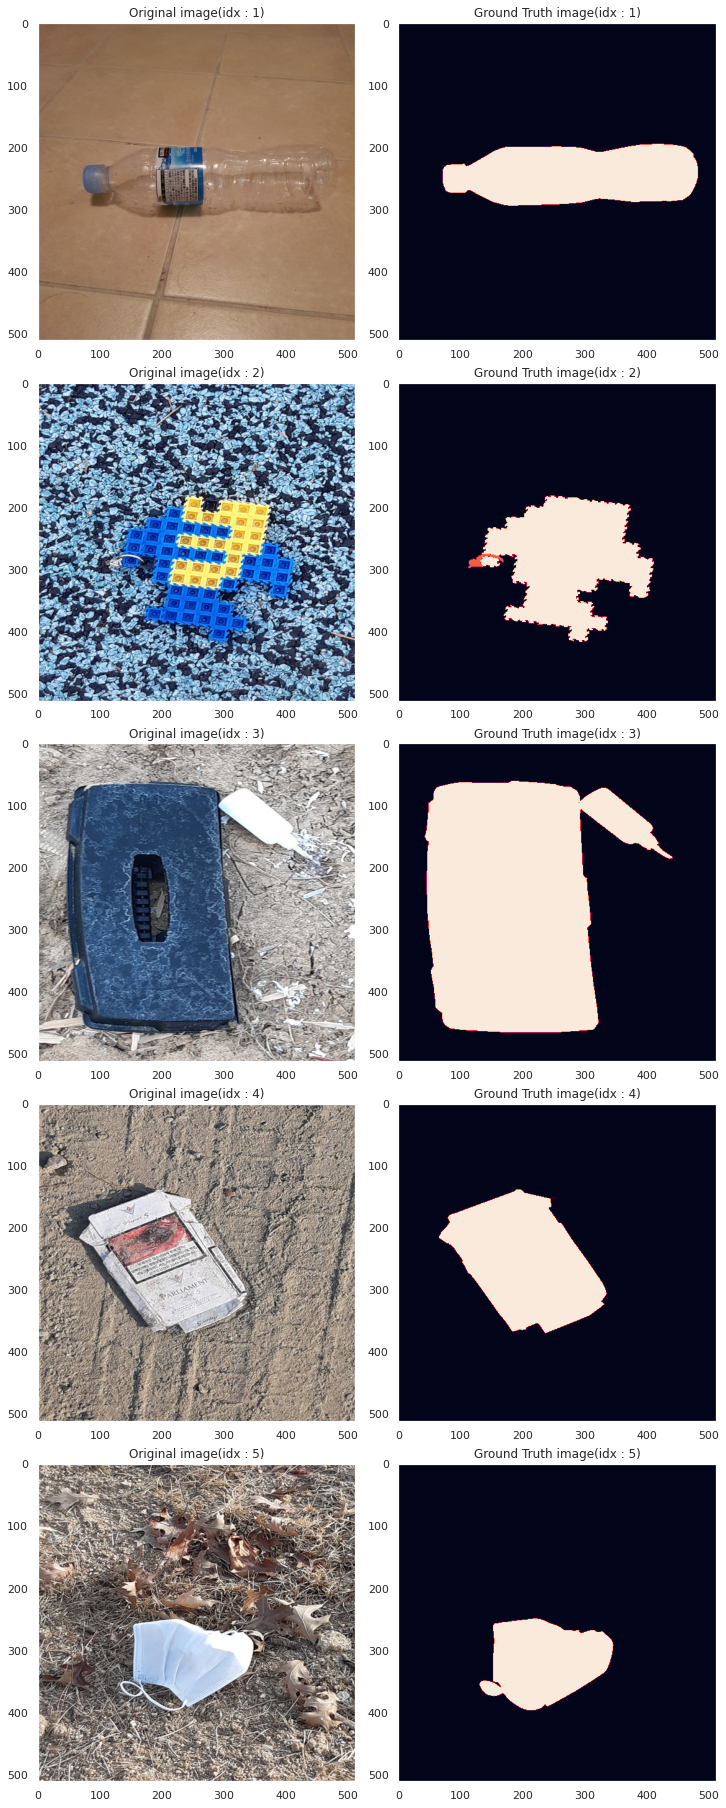

In [12]:
visualization_with_matplotlib([1,2,3,4,5]) # 실행하는 함수 argment는 저렇게 넣어도 된다.